# DADI Jupyter notebook

https://dadi.readthedocs.io/en/latest/user-guide/installation/

git clone https://bitbucket.org/gutenkunstlab/dadi.git

In [1]:
# Numpy is the numerical library dadi is built upon
from numpy import array

import dadi

import dadi.NLopt_mod

# In demographic_models.py, we've defined a custom model for this problem
import demographic_models

In [2]:
# Load the data
data = dadi.Spectrum.from_file('YRI_CEU.fs')
ns = data.sample_sizes

# These are the grid point settings will use for extrapolation.
pts_l = [40,50,60]

# The Demographics1D and Demographics2D modules contain a few simple models,
# mostly as examples. We could use one of those.
func = dadi.Demographics2D.split_mig
# Instead, we'll work with our custom model
func = demographic_models.prior_onegrow_mig

In [3]:
# Now let's optimize parameters for this model.

# The upper_bound and lower_bound lists are for use in optimization.
# Occasionally the optimizer will try wacky parameter values. We in particular
# want to exclude values with very long times, very small population sizes, or
# very high migration rates, as they will take a long time to evaluate.
# Parameters are: (nu1F, nu2B, nu2F, m, Tp, T)
upper_bound = [100, 100, 100, 10, 3, 3]
lower_bound = [1e-2, 1e-2, 1e-2, 0, 0, 0]


In [6]:
# This is our initial guess for the parameters, which is somewhat arbitrary.
p0 = [2,0.1,2,1,0.2,0.2]
# Make the extrapolating version of our demographic model function.
func_ex = dadi.Numerics.make_extrap_log_func(func)

# Perturb our parameters before optimization. This does so by taking each
# parameter a up to a factor of two up or down.
p0 = dadi.Misc.perturb_params(p0, fold=1, upper_bound=upper_bound,
                              lower_bound=lower_bound)
# Do the optimization. By default we assume that theta is a free parameter,
# since it's trivial to find given the other parameters. If you want to fix
# theta, add a multinom=False to the call.
# The maxtime  argument here shuts the optimization down after a short time.
# For real runs, you won't want this restriction.
# You will also want to run optimization several times
# using multiple sets of intial parameters, to be confident you've actually
# found the true maximum likelihood parameters.
print('Beginning optimization ************************************************')
popt = dadi.NLopt_mod.opt(p0, data, func_ex, pts_l, 
                                   lower_bound=lower_bound,
                                   upper_bound=upper_bound,
                                 maxtime=120, verbose=len(p0))
# The verbose argument controls how often progress of the optimizer should be
# printed. It's useful to keep track of optimization process.
print('Finshed optimization **************************************************')

Beginning optimization ************************************************
444     , -2994.9     , array([ 2.23629    ,  0.338396   ,  1.94893    ,  1.9978     ,  0.37208    ,  0.267781   ])
450     , -1756.15    , array([ 2.23629    ,  0.0569137  ,  1.94893    ,  1.9978     ,  0.37208    ,  0.267781   ])
456     , -1481.47    , array([ 2.16958    ,  0.238663   ,  0.237907   ,  2.53932    ,  0.367903   ,  0.260062   ])
462     , -1232.72    , array([ 2.21326    ,  0.198777   ,  0.462331   ,  2.01746    ,  0.398579   ,  0.269341   ])
468     , -1208.86    , array([ 2.04841    ,  0.205734   ,  0.600797   ,  1.88672    ,  0.367856   ,  0.263658   ])
474     , -1157.84    , array([ 1.72164    ,  0.198287   ,  0.593198   ,  1.82744    ,  0.394132   ,  0.26446    ])
480     , -1143.27    , array([ 1.61023    ,  0.19565    ,  0.53423    ,  1.83555    ,  0.393576   ,  0.256206   ])
486     , -1140.45    , array([ 1.61267    ,  0.195256   ,  0.512067   ,  1.82809    ,  0.392724   ,  0.257904   ])


Best-fit parameters: [1.88, 0.0724, 1.764, 0.93, 0.363, 0.112]
Maximum log composite likelihood: -1066.2652456575374
Optimal value of theta: 2743.963580382483


/opt/conda/lib/python3.8/site-packages/dadi/Plotting.py:167: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("hsv"))
  pylab.cm.hsv.set_under('w')


AttributeError: module 'dadi' has no attribute 'Godambe'

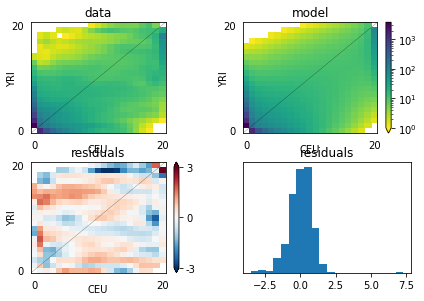

In [7]:
# These are the actual best-fit model parameters, which we found through
# longer optimizations and confirmed by running multiple optimizations.
# We'll work with them through the rest of this script.
popt = [1.880, 0.0724, 1.764, 0.930, 0.363, 0.112]
print('Best-fit parameters: {0}'.format(popt))

# Calculate the best-fit model AFS.
model = func_ex(popt, ns, pts_l)
# Likelihood of the data given the model AFS.
ll_model = dadi.Inference.ll_multinom(model, data)
print('Maximum log composite likelihood: {0}'.format(ll_model))
# The optimal value of theta given the model.
theta = dadi.Inference.optimal_sfs_scaling(model, data)
print('Optimal value of theta: {0}'.format(theta))

# Plot a comparison of the resulting fs with the data.
import pylab
pylab.figure(1)
dadi.Plotting.plot_2d_comp_multinom(model, data, vmin=1, resid_range=3,
                                    pop_ids =('YRI','CEU'), show=False)
# Save the figure
pylab.savefig('YRI_CEU.png', dpi=250)

# To use the GIM approach, we need to have spectra from bootstrapping our 
# data.  Let's load the ones we've provided for the example.  
# (We're using Python list comprehension syntax to do this in one line.)
all_boot = [dadi.Spectrum.from_file('bootstraps/{0:02d}.fs'.format(ii)) 
            for ii in range(100)]
uncerts = dadi.Godambe.GIM_uncert(func_ex, pts_l, all_boot, popt, data, 
                                  multinom=True)
# uncert contains the estimated standard deviations of each parameter, with
# theta as the final entry in the list.
print('Estimated parameter standard deviations from GIM: {0}'.format(uncerts))

# For comparison, we can estimate uncertainties with the Fisher Information
# Matrix, which doesn't account for linkage in the data and thus underestimates
# uncertainty. (Although it's a fine approach if you think your data is truly
# unlinked.)
uncerts_fim = dadi.Godambe.FIM_uncert(func_ex, pts_l, popt, data, multinom=True)
print('Estimated parameter standard deviations from FIM: {0}'.format(uncerts_fim))

print('Factors by which FIM underestimates parameter uncertainties: {0}'.format(uncerts/uncerts_fim))

# What if we fold the data?
# These are the optimal parameters when the spectrum is folded. 
popt_fold = [1.910, 0.074, 1.787, 0.914, 0.439, 0.114]
all_boot_fold = [_.fold() for _ in all_boot]
uncerts_folded = dadi.Godambe.GIM_uncert(func_ex, pts_l, all_boot_fold,
                                         popt_fold, data.fold(), multinom=True)
print('Folding increases parameter uncertainties by factors of: {0}'.format(uncerts_folded/uncerts))

# Let's do a likelihood-ratio test comparing models with and without migration.
# The no migration model is implemented as 
# demographic_models.prior_onegrow_nomig
func_nomig = demographic_models.prior_onegrow_nomig
func_ex_nomig = dadi.Numerics.make_extrap_log_func(func_nomig)
# These are the best-fit parameters, which we found by multiple optimizations
popt_nomig = array([ 1.897,  0.0388,  9.677,  0.395,  0.070])
model_nomig = func_ex_nomig(popt_nomig, ns, pts_l)
ll_nomig = dadi.Inference.ll_multinom(model_nomig, data)

# Since LRT evaluates the complex model using the best-fit parameters from the
# simple model, we need to create list of parameters for the complex model
# using the simple (no-mig) best-fit params.  Since evalution is done with more
# complex model, need to insert zero migration value at corresponding migration
# parameter index in complex model. And we need to tell the LRT adjust function
# that the 3rd parameter (counting from 0) is the nested one.
p_lrt = [1.897,  0.0388,  9.677, 0, 0.395,  0.070]

adj = dadi.Godambe.LRT_adjust(func_ex, pts_l, all_boot, p_lrt, data, 
                              nested_indices=[3], multinom=True)
D_adj = adj*2*(ll_model - ll_nomig)
print('Adjusted D statistic: {0:.4f}'.format(D_adj))

# Because this is test of a parameter on the boundary of parameter space 
# (m cannot be less than zero), our null distribution is an even proportion 
# of chi^2 distributions with 0 and 1 d.o.f. To evaluate the p-value, we use the
# point percent function for a weighted sum of chi^2 dists.
pval = dadi.Godambe.sum_chi2_ppf(D_adj, weights=(0.5,0.5))
print('p-value for rejecting no-migration model: {0:.4f}'.format(pval))

# This ensures that the figures pop up. It may be unecessary if you are using
# ipython.
pylab.show()

In [8]:
import ipywidgets as widgets

In [9]:
widgets.FloatSlider(
    value=7.5,
    min=0,
    max=10.0,
    step=0.1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

FloatSlider(value=7.5, continuous_update=False, description='Test:', max=10.0, readout_format='.1f')

# Jupyter Interact Controls
https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20List.html

In [ ]:
https://ipywidgets.readthedocs.io/en/stable/examples/Output%20Widget.html

In [ ]:
https://towardsdatascience.com/bring-your-jupyter-notebook-to-life-with-interactive-widgets-bc12e03f0916